In [85]:
import sunpy.map
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as pf
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.coordinates.transformations
from sunpy.coordinates import frames
import astropy.units as u
import os
import glob
# For label
from scipy.ndimage.measurements import label, find_objects, center_of_mass
from scipy.ndimage.morphology import generate_binary_structure

import matplotlib
# This makes nice big plots for matplotlib
import matplotlib as mpl


params = {'font.size': 14,
          'figure.figsize': (30.0, 16.0),
          'lines.linewidth': 2.,
          'lines.markersize': 15,
          'animation.embed_limit': 2048,
          }
mpl.rcParams.keys()
mpl.rcParams.update(params)
np.set_printoptions(suppress=True)


data_dir = os.path.abspath("/home/lazar/Fak(s)/AF/prakse/SDSA/data")

bitmaps = sorted(glob.glob(os.path.join(
    data_dir, "3481_11923_SHARP_CEA_bitmaps/*bitmap*")))
cont = sorted(glob.glob(os.path.join(
    data_dir, "3481_11923_SHARP_CEA_enhanced_norm/*enhanced_normalized*")))

Br_list = sorted(glob.glob(os.path.join(
    data_dir, "3481_11923_SHARP_CEA_upscaled_magnetic_data/*Br*")))
Bp_list = sorted(glob.glob(os.path.join(
    data_dir, "3481_11923_SHARP_CEA_upscaled_magnetic_data/*Bp*")))
Bt_list = sorted(glob.glob(os.path.join(
    data_dir, "3481_11923_SHARP_CEA_upscaled_magnetic_data/*Bt*")))

imgnumber = 80

print(cont[imgnumber])
#x = sunpy.map.Map(bitmaps[601])
y = sunpy.map.Map(cont[imgnumber])
bz = sunpy.map.Map(Br_list[imgnumber])
bx = sunpy.map.Map(Bp_list[imgnumber])
# for some reason this should be -y ??? YOU NEED TO CHANGE THE SIGN
by = sunpy.map.Map(Bt_list[imgnumber])

/home/lazar/Fak(s)/AF/prakse/SDSA/data/3481_11923_SHARP_CEA_enhanced_norm/hmi.sharp_cea_720s.3481.20131209_031200_TAI.enhanced_normalized.fits


In [86]:
#X = np.argwhere((mapa.data <= 0.5) & (mapa.data > 0))
X = np.ma.masked_where((y.data <= 0.5) & (y.data > 0), y.data)

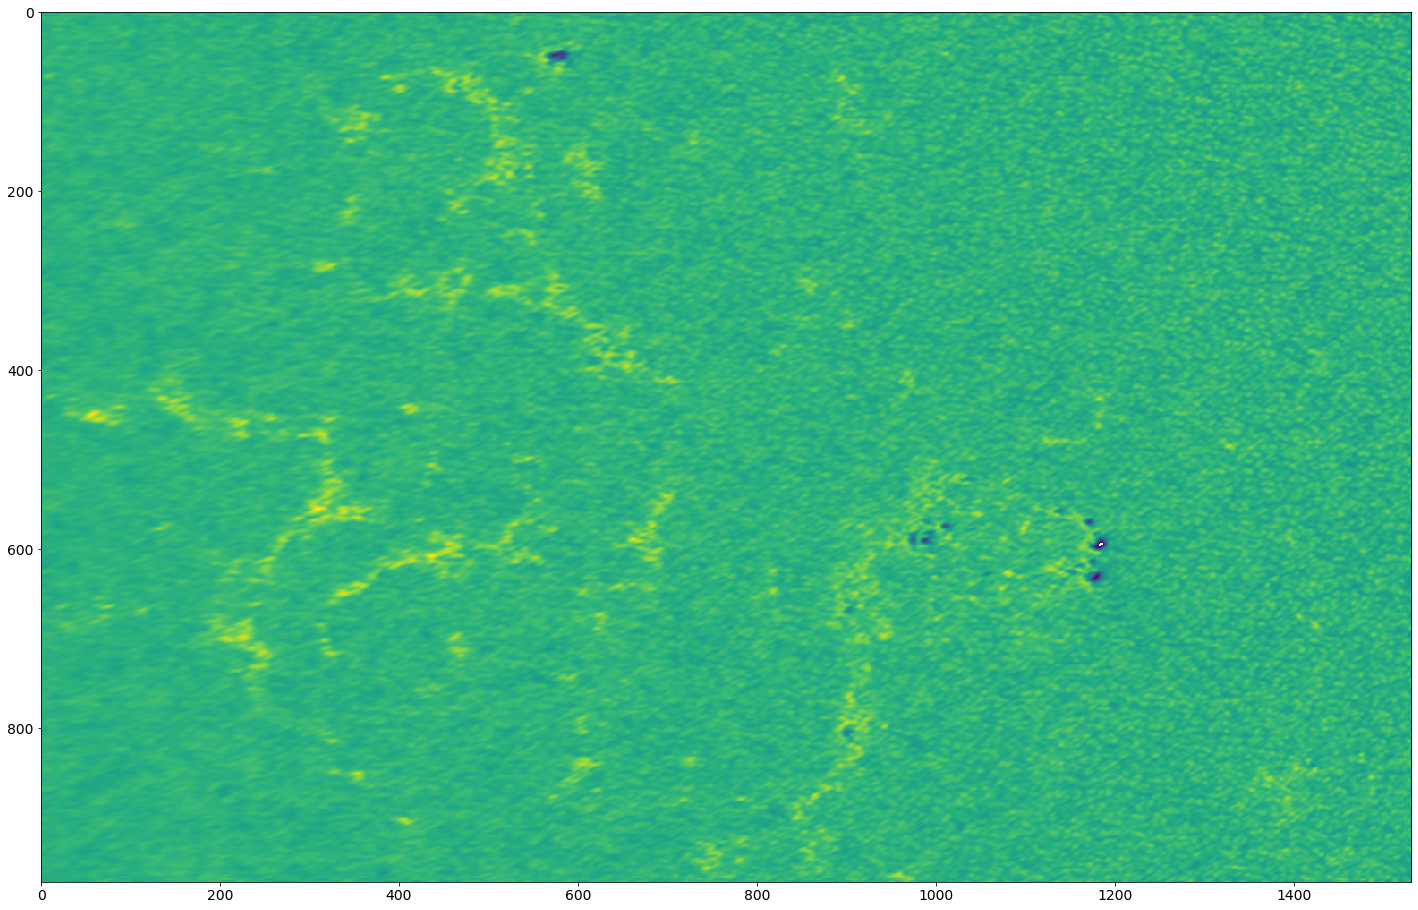

In [87]:
plt.imshow(X)  # [550:750,800:1200])

In [88]:
# https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html
#s = generate_binary_structure(2,2)

# THIS IS CONST!
SMALL_PATCH_LIMIT = 20

# big and small endian probles, idk why, newbyteorder() fixed it ¯\_(ツ)_/¯
# label and create patches
labeled_array, num_features = label(X.mask.newbyteorder())
print(num_features)
# find how many pixel is in each patch
regions, counts = np.unique(labeled_array, return_counts=True)


#print(regions.shape)

# if pixel count for patch is smaller then SMALL_PATCH LIMIT
# This labels of patches with small pixel count
remove_patches = (counts < SMALL_PATCH_LIMIT).nonzero()[0]
# Set it to zero
for i in remove_patches:
    labeled_array[labeled_array == i] = 0


# THIS IS LAZY PROGRAMMING!!! DONT DO THIS!
# i wanted smooth region labelin (0,1,2,3,4) not gapped (0,1,4,6,7), i could do that manually, but im lazy
labeled_array1, num_features1 = label(labeled_array)
print(num_features1)
#cmass = center_of_mass(labeled_array, labels=labeled_array1)
# print(cmass)
# print(np.asarray(range(1,num_features1+1)))
# print(num_features)
# X.shape
#
# print(num_features1)
# print(list(range(1,num_features1+1)))
# Create new mask with removed small patches
X = np.ma.masked_where(labeled_array1 > 0, y.data)

#######
# lets calculate centers of patches
features_label = np.arange(1, num_features1+1, 1)
cmass = center_of_mass(labeled_array, labeled_array1, features_label)
# print(labeled_array)

# for every labeled structure, calculate mean field vector
# for i in features_label:
# avg_bz =
# print(cmass)

1
0


In [89]:
def get_patches_and_vectors(I, bx, by, bz, pixel_limit=20, thr=0.5):
    '''
    I - intensity map for detecting pores; should be normalized to quiet sun
    bx - bx data (should be Bp from sharps) type should be sunpy map
    by - by data (should be Bt from sharps) type should be sunpy map. DO NOT CHANGE SIGN OF DATA, THIS FUNCTION WILL DO IT!
    bz - bz data (should be Br from sharps) type should be sunpy map
    pixel_limit - ignore patches that are smaller than this size
    thr - if I < thr => we assign it as pixel of interes
    '''
    # Create masked array from I data
    X = np.ma.masked_where((I.data <= 0.5) & (I.data > 0), I.data)
    try:
        # sometimes this fails because of endianness
        labeled_array, num_features = label(X.mask)
    except:
        labeled_array, num_features = label(X.mask.newbyteorder())

    # find how many pixel is in each patch
    regions, counts = np.unique(labeled_array, return_counts=True)
    
    #That means we only have 0 patches, only background!
    #print(regions.shape[0])
    #jesus man, this hack, cant force None to work later on while comparing!!!! JESUS!!!
    if regions.shape[0] == 1:
        return np.zeros([])
        
    # if pixel count for patch is smaller then pixel_limit
    # This labels of patches with small pixel count
    remove_patches = (counts < pixel_limit).nonzero()[0]
    # Set it to zero
    for i in remove_patches:
        labeled_array[labeled_array == i] = 0

    # THIS IS LAZY PROGRAMMING!!! DONT DO THIS!
    # i wanted smooth region labelin (0,1,2,3,4) not gapped (0,1,4,6,7), i could do that manually, but im lazy
    labeled_array1, num_features1 = label(labeled_array)

    #X = np.ma.masked_where(labeled_array1 > 0, I.data)

    #######
    # lets calculate centers of patches
    # Actuall patches are marked as 1 and above, 0 is background
    features_label = np.arange(1, num_features1+1, 1)
    cmass = center_of_mass(labeled_array, labeled_array1, features_label)
    # print(labeled_array)

    # Create placeholder matrix that has
    # cx, cy, <bx>, <by>, <bz>
    RETURN_MATRIX = np.zeros([len(cmass), 5])

    for pore_index in features_label:
        # valid pixels for that pore index over which we should average
        valid_pixels = np.argwhere(labeled_array1 == pore_index)
        # for some reason x is normal here
        RETURN_MATRIX[pore_index - 1][0] = cmass[pore_index-1][0]
        RETURN_MATRIX[pore_index - 1][1] = cmass[pore_index-1][1]
        RETURN_MATRIX[pore_index - 1][2] = np.mean(bx.data[valid_pixels[:, 0], valid_pixels[:, 1]])
        RETURN_MATRIX[pore_index - 1][3] = np.mean(-by.data[valid_pixels[:, 0], valid_pixels[:, 1]])
        RETURN_MATRIX[pore_index - 1][4] = np.mean(bz.data[valid_pixels[:, 0], valid_pixels[:, 1]])

    return RETURN_MATRIX#, labeled_array1, num_features1 #, I ZELIM CELU MASKU ZA SVAKI SLUCAJ!

#lets time it
import time
start = time.time()
print("hello")

replace_this = 'enhanced_normalized.fits'
with_this = 'patches.txt'

def touch(path):
    with open(path, 'a'):
        os.utime(path, None)
        
for i in range(len(cont)):
    #print(i)
    I = sunpy.map.Map(cont[i])
    bz = sunpy.map.Map(Br_list[i])
    bx = sunpy.map.Map(Bp_list[i])
    # for some reason this should be -y ??? (CHANGED IN FUNCTION!, just pass by)
    by = sunpy.map.Map(Bt_list[i])
    save_matrix = get_patches_and_vectors(I, bx, by, bz)
    outfile = os.path.basename(cont[i]).replace(
        replace_this, with_this)
    outdir = os.path.dirname(cont[i])
    ofile = os.path.join(outdir, outfile)
    #print(save_matrix.size)
    if save_matrix.size == 1:# == None:
        touch(ofile)
        continue
    #print(save_matrix)
    np.savetxt(ofile, save_matrix)


end = time.time()
print(end - start)

TRY_MATRIX = get_patches_and_vectors(y, bx, by, bz)

print(TRY_MATRIX[:,0])

# for every labeled structure, calculate mean field vector
# for i in features_label:
# avg_bz =
# print(cmass)

hello
117.8125364780426
[]


In [30]:
# print(cmass[0])
BZ_MEAN = np.array([])
for pore_index in features_label:
    print("Calculating field for pore %s, with cmass (%d, %d)" %
          (pore_index, cmass[pore_index-1][0], cmass[pore_index-1][1]))
    valid_pixels = np.argwhere(labeled_array1 == pore_index)
    print(np.mean(bz.data[valid_pixels[:, 0], valid_pixels[:, 1]]))
    print(np.mean(bx.data[valid_pixels[:, 0], valid_pixels[:, 1]]))
    print(np.mean(by.data[valid_pixels[:, 0], valid_pixels[:, 1]]))
    # BZ_MEAN.append()
#pore_index = np.argwhere(labeled_array1 == 1)
# pore_index[:,0]
# np.mean(bz.data[pore_index[:,0],pore_index[:,1]])

Calculating field for pore 1, with cmass (593, 1117)
-1458.8343893775677
-68.2596217221503
84.46813461660633
Calculating field for pore 2, with cmass (618, 1106)
-1380.4694705930613
-39.123668715674775
334.0786621877176
Calculating field for pore 3, with cmass (653, 1080)
-1177.0409325583018
101.7463678738929
554.9544818405986
Calculating field for pore 4, with cmass (664, 849)
1420.3070130406754
-256.0928614429355
256.61966711016396
Calculating field for pore 5, with cmass (668, 965)
1292.2892162969256
465.23484707644224
28.911456593289763
Calculating field for pore 6, with cmass (680, 859)
1693.5733446893137
-93.88633979956137
-231.6021820424218


[1117.70588235 1106.08547009 1080.60606061  849.97590361  965.46666667
  859.49101796]


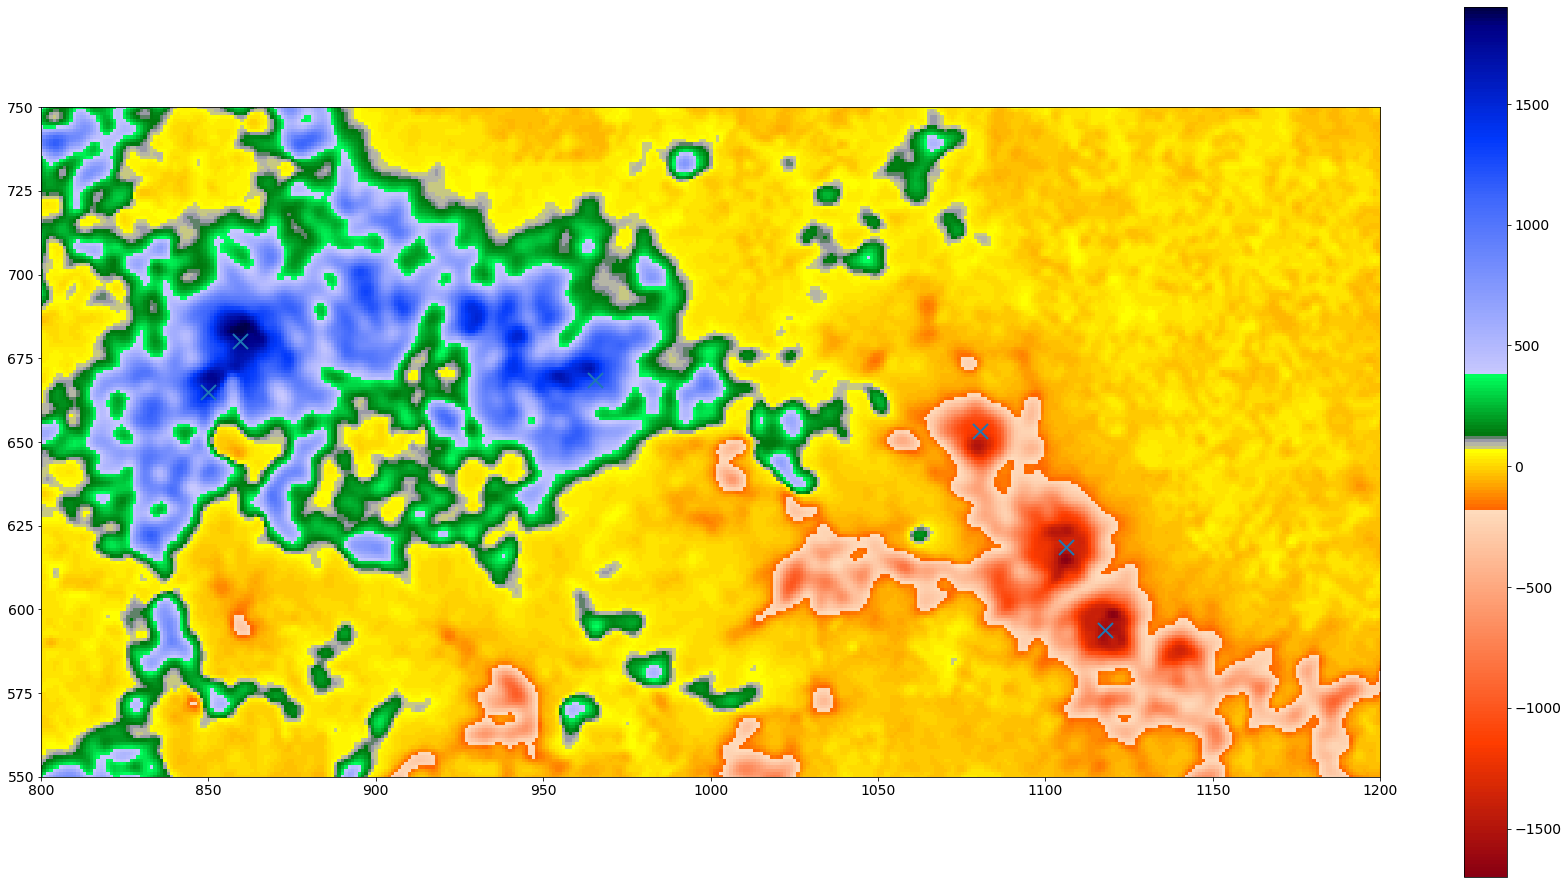

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sunpy.cm import color_tables as ct
hmimag = plt.get_cmap('hmimag')

patch = [(550, 750), (800, 1200)]
plt.xlim(patch[1])
plt.ylim(patch[0])
# plt.imshow(X,zorder=1,cmap='gray')
#Z = np.ma.masked_where(labeled_array > 0, labeled_array)
plt.imshow(bz.data, zorder=0, cmap=hmimag)
plt.colorbar()

print(TRY_MATRIX[:,1])
plt.scatter(TRY_MATRIX[:,1], TRY_MATRIX[:,0], zorder=10, marker='x')

#plt.scatter(cmass[0][1], cmass[0][0], zorder=10, marker='x', c='blue')
#plt.scatter(cmass[1][1], cmass[1][0], zorder=10, marker='x', c='blue')
#plt.scatter(cmass[2][1], cmass[2][0], zorder=10, marker='x', c='blue')
#plt.scatter(cmass[3][1], cmass[3][0], zorder=10, marker='x', c='red')
#plt.scatter(cmass[4][1], cmass[4][0], zorder=10, marker='x', c='red')
#plt.scatter(cmass[5][1], cmass[5][0], zorder=10, marker='x', c='red')

In [40]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
plt.clf()
fig = plt.figure(1)
ax = fig.gca(projection='3d')
#X, Y, Z = axes3d.get_test_data(0.05)
X = np.arange(bz.data.shape[1])
Y = np.arange(bz.data.shape[0])
XX, YY = np.meshgrid(X, Y)
# ax.plot_surface(XX, YY, , rstride=8, cstride=8, alpha=0.3)
patch = [(550, 750), (800, 1200)]
ax.set_xlim(patch[1])
ax.set_ylim(patch[0])
ax.set_zlim([-1, 1])
cset = ax.contourf(XX, YY, bz.data, zdir='z', offset=0.4,
                   levels=np.linspace(-2000, 2000, 50), cmap=hmimag)

#soa = np.array([[0, 0, 1, 1, -2, 0], [0, 0, 2, 1, 1, 0],[0, 0, 3, 2, 1, 0], [0, 0, 4, 0.5, 0.7, 0]])

#X, Y, Z, U, V, W = zip(*soa)
valid_pixels = np.argwhere(labeled_array1 == 1)
bz1 = np.mean(bz.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000
bx1 = np.mean(bx.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000
by1 = np.mean(-by.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000

valid_pixels = np.argwhere(labeled_array1 == 2)
bz2 = np.mean(bz.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000
bx2 = np.mean(bx.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000
by2 = np.mean(-by.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000

valid_pixels = np.argwhere(labeled_array1 == 3)
bz3 = np.mean(bz.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000
bx3 = np.mean(bx.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000
by3 = np.mean(-by.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000

valid_pixels = np.argwhere(labeled_array1 == 4)
bz4 = np.mean(bz.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000
bx4 = np.mean(bx.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000
by4 = np.mean(-by.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000

valid_pixels = np.argwhere(labeled_array1 == 5)
bz5 = np.mean(bz.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000
bx5 = np.mean(bx.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000
by5 = np.mean(-by.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000

valid_pixels = np.argwhere(labeled_array1 == 6)
bz6 = np.mean(bz.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000
bx6 = np.mean(bx.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000
by6 = np.mean(-by.data[valid_pixels[:, 0], valid_pixels[:, 1]])/1000


vectors = [[cmass[0][1], cmass[0][0], 0.4, bx1, by1, bz1],
           [cmass[1][1], cmass[1][0], 0.4, bx2, by2, bz2],
           [cmass[2][1], cmass[2][0], 0.4, bx3, by3, bz3],
           [cmass[3][1], cmass[3][0], 0.4, bx4, by4, bz4],
           [cmass[4][1], cmass[4][0], 0.4, bx5, by5, bz5],
           [cmass[5][1], cmass[5][0], 0.4, bx6, by6, bz6]]

X, Y, Z, U, V, W = zip(*vectors)

ax.quiver(X, Y, Z, U, V, W)